# Forward and Backward Propagation 구현

- single hidden layer 의 이진 분류 neural network
- cross entropy loss 계산
- forward and backward propagation 구현  

- [Original source from Coursera - Andrew Ng.](https://github.com/Kulbear/deep-learning-coursera/blob/master/Neural%20Networks%20and%20Deep%20Learning/Planar%20data%20classification%20with%20one%20hidden%20layer.ipynb)

<img src="grad_summary.png" style="width:600px;height:300px;">

$Z = Wa + b$  
$a = sig(Z)$  
$L(a, y) = -[y\cdot log{a} - (1-y)\cdot log(1-a)]$  


- 출력층의 $\frac{dL}{dZ}$   
$\frac{dL}{da} = -[y\cdot\frac{1}{a} - (1-y)\cdot \frac{1}{1-a}]$  
$\frac{dL}{dZ} = \frac{dL}{da}\frac{da}{dZ} = (-\frac{y}{a}+\frac{1-y}{1-a})\cdot a(1-a) = a - y$


- $\frac{dL}{dW}$  
$\frac{dZ}{dW} = \frac{d}{dW}(W^{[l]} a^{[l-1]}+b^{[l]}) = a^{[l-1]}$  
$\frac{dL}{dW} = \frac{dL}{dZ}\frac{dZ}{dW} = (a^{[l]} - y)\cdot a^{[l-1]} = \frac{dL}{dZ}\cdot a^{[l-1]}$  


- $\frac{dL}{db}$  
$\frac{dZ}{db} = \frac{d}{db}(W^{[l]} a^{[l-1]}+b^{[l]}) = 1$  
$\frac{dL}{db} = \frac{dL}{dZ}\frac{dZ}{db} = \frac{dL}{dZ}$  


- 은닉층의 $\frac{dL}{dZ}$   
$Z^2 = W^2 \cdot a(Z^1) + b^2$   
$\frac{dZ^2}{dZ^1} = W^2\cdot g^{1\prime} (Z^1)$   
$\frac{dL}{dZ^1} = \frac{dL}{dZ^2}\frac{dZ^2}{dZ^1} = \frac{dL}{dZ^2}\cdot W^2 \cdot g^{1\prime} (Z^1)$  

### 출력층
- output A, true value Y  
- Loss = binary-crossentropy ($-[ylog{\hat{y}} + (1-y)log{(1-\hat{y})}]$)

    1. $dZ^{[L]} = A^{[L]}-Y \rightarrow$ 출력층의 $dZ$
    2. $dW^{[L]} = dZ^{[L]}A^{[L-1]} \rightarrow$ 현재층의 $dW$는 현재층의 $dZ$ 곱하기 이전층의 출력 
    3. $db^{[L]} = dZ^{[L]} \rightarrow$ 현재층의 $db$는 현재층의 $dZ$
    
### 은닉층
-  
    4. $dZ^{[L]} = W^{[L+1]}dZ^{[L+1]}\cdot g^{[L]\prime} (Z^{[L]}) \rightarrow$ 현재층의 $dZ$은 다음층의 weight와  $dZ$의 행렬곱 곱하기 현재층의 activation의 미분값
    5. $dW^{[L]} = dZ^{[L]}A^{[L-1]} \rightarrow$ 현재층의 $dW$는 현재층의 $dZ$ 곱하기 이전층의 출력 (이전층이 입력층이면 input data)
    6. $db^{[L]} = dZ^{[L]} \rightarrow$ 현재층의 $db$는 현재층의 $dZ$

In [1]:
import h5py 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
def sigmoid(Z):
    """
    Arguments:
        Z -- logit   
    Returns:
        A -- output of sigmoid(z), same shape as Z
        cache -- backpropagation에 사용하게 위해 Z 저장
    """
    A = 1/(1+np.exp(-Z))
    
    return A, Z

def relu(Z):
    """
    Arguments:
        Z -- logit
    Returns:
        A -- output of relu, the same shape as Z
        cache -- backpropagation에 사용하게 위해 A 저장
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)

    return A, Z


def relu_backward(dA, cache):
    """
    Arguments:
        dA -- dL/dA
        cache -- 저장된 forward prop. 의 'Z' 
    Returns:
        dZ -- Z에 대한 cost 의 gradient
    """
    
    Z = cache
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ = np.where(Z > 0, dA, 0)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def sigmoid_backward(dA, cache):
    """
    Arguments:
        dA -- dL/dA
        cache -- 저장된 forward prop. 의 'Z' 
    Returns:
        dZ -- Z에 대한 cost 의 gradient
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

## 구현 순서

1) 2 layer Network와 $L$ 계층 신경망에 대한 parameter 를 초기화  

2) 순방향 전파 모듈을 구현(아래 그림 보라색)
- pre-activation(LINEAR) ($Z^{[l]}$)
- ACTIVATION (relu / sigmoid)
- 두 단계를 새로운 [LINEAR-> ACTIVATION] forward function으로 결합
- [LINEAR-> RELU] forward function L-1 회 (layer 1 ~ L-1)을 스택하고 끝에 [LINEAR-> SIGMOID]를 추가 (최종 layer $L$) --> L_model_forward 함수.
    
3) 손실 계산  


4) 역방향 전파 모듈 (아래 그림에서 빨간색으로 표시)을 구현  
- 레이어의 역전파 단계의 LINEAR 부분을 완료
- ACTIVATE 함수 (relu_backward / sigmoid_backward)의 기울기를 제공
- 이전 두 단계를 새로운 [LINEAR-> ACTIVATION] backward function으로 결합
- 새 L_model_backward 함수에서 [LINEAR-> RELU]를 뒤로 L-1 번 스택하고 [LINEAR-> SIGMOID]를 뒤로 추가

5) 마지막으로 매개 변수를 업데이트  

<img src="final outline.png" style="width:800px;height:500px;">
<caption><center> **Figure 1**</center></caption><br>

## 1) parameter 초기화

model의 $L$ 레이어들의 parameter 를 초기화하는 함수를 작성.

- random initialization  
    - 가중치 행렬에 대해 임의 초기화를 사용 : `np.random.randn(shape)*0.01`
    - 초기화 값에 0.01과 같은 작은 스칼라 값를 곱하여 활성화 함수의 derivative 가 0 에 가깝지 않은 영역에 있도록 함  


- Xavier initialization  

    $$random initialization * \sqrt{\frac{1.}{size^{[l-1]}}}$$
    
    
- bias 에 대해 0 초기화 : `np.zeros(shape)`

In [3]:
def initialize_parameters(layer_dims, xavier=False):
    """
    Arguments:
    layer_dims -- 네트워크의 각 계층의 dimension을 포함하는 파이썬 배열(list)
    
    Returns:
    parameters -- "W1", "b1", ..., "WL", "bL" 매개 변수를 포함하는 파이썬 dictionary:
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(101)
    
    parameters = {}
    L = len(layer_dims)     # number of layers in the network

    
    for layer in range(1, L):
        cdim, pdim = layer_dims[layer], layer_dims[layer-1]
        if xavier:
            parameters['W'+str(layer)] = np.random.randn(cdim, pdim) * np.sqrt(1./cdim)
            parameters['b'+str(layer)] = np.zeros((cdim, 1))
        else:
            parameters['W'+str(layer)] = np.random.randn(cdim, pdim) * 0.01
            parameters['b'+str(layer)] = np.zeros((cdim, 1))
     
    return parameters

In [30]:
parameters = initialize_parameters([784, 64, 16, 1]) # 입력 5, 출력 1

print(parameters['W1'].shape, parameters['W2'].shape, parameters['W3'].shape)

(64, 784) (16, 64) (1, 16)


파이썬에서 $W X + b$ 를 계산할 때 브로드 캐스팅을 수행한다는 것을 기억. 

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}$$

일 경우 $WX + b$ 는:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}$$

## 2) Forward Propagation

### Pre-Activation Forward


linear forward 모듈은 다음 방정식을 계산.

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$

여기서 $A^{[0]} = X$ (입력 data).

이전 계층의 입력이 주어지면 각 neuron은 $z = W ^ Tx + b$ 를 계산 한 다음 ReLU와 같은 활성화 함수 g(z)를 적용. 이 과정에서 역전파에 사용될 각 레이어에서 계산되고 사용되는 모든 변수를 저장(캐시). 

In [5]:
def linear_forward(A_prev, W, b, activation_fn):
    """
    Arguments:
    A_prev -- activations from previous layer (or input data): (number of features, size of previous layer)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    Returns:
    Z -- 활성화 함수의 입력, also called pre-activation parameter 
    cache -- "A_pre", "W", "b" 및 Z를 포함하는 파이썬 dictionary
    """
    # 이전 layer 의 output(A_prev)과 current layer 의 weight 를 곱하여 새로운 logit 생성
    Z = np.dot(W, A_prev) + b
    
    if activation_fn == "sigmoid":
        A, activation_cache = sigmoid(Z)                # A, Z
    elif activation_fn == "relu":
        A, activation_cache = relu(Z)                   # A, Z
    else:
        print("Invalid activation_fn")
        
    # backpropagation 에 사용하기 위해 A_prev, W, b 를 cache 에 저장
    cache = ((A_prev, W, b), Z)            #((A_prev, W, b), Z)
    # logit 을 activation 함수에 적용한 output 과 cache 를 반환
    return A, cache    

- linear_activation_forward 를 L개 층으로 일반화

In [6]:
def L_model_forward(X, parameters):
    A = X                           
    caches = []                     
    L = len(parameters) // 2 # w, b 함께 있으므로 2 로 나누어줌    

    # 입력층과 은닉층의 activation, W, b, Z 계산
    for layer in range(1, L):
        A_prev = A
        A, cache = linear_forward(
            A_prev, parameters["W" + str(layer)], parameters["b" + str(layer)], activation_fn="relu")
        caches.append(cache)

    # 출력층 의 activation, W, b, Z 계산
    AL, cache = linear_forward(
        A, parameters["W" + str(L)], parameters["b" + str(L)], activation_fn="sigmoid")
    caches.append(cache)

    assert AL.shape == (1, X.shape[1])
    return AL, caches   # AL: Last Activation

## 3) Loss 계산

In [7]:
# binary cross-entropy cost 계산
def compute_cost(AL, y):
    m = y.shape[1]              
    cost = - (1 / m) * np.sum(
        np.multiply(y, np.log(AL)) + np.multiply(1 - y, np.log(1 - AL)))
    return cost

## Back-Propagation

그래디언트를 계산하기 위해 cost 함수로 부터 네트워크를 통해 거꾸로 정보가 되돌아 갈 수 있도록 합니다. 이렇게 하면 누가 가장 많은 오류를 일으키는지 파악하여 그 방향으로 parameter 를 update 할 수 있습니다.  

- 출력층 Last activation :  $\frac{dL}{da} = -[y\cdot \frac{1}{a} - (1-y)\cdot \frac{1}{1-a}] = -\frac{y}{a}+\frac{1-y}{1-a} = -\frac{y(1-a)}{a(1-a)} - \frac{a-ay}{a(1-a)} = \frac{-y+ay+a-ay}{a(1-a)} = \frac{a-y}{a(1-a)}$

In [8]:
def sigmoid_gradient(dA, Z):
    A, Z = sigmoid(Z)
    dZ = dA * A * (1 - A)

    return dZ


def relu_gradient(dA, Z):
    A, Z = relu(Z)
    dZ = np.multiply(dA, np.int64(A > 0))  # true 이면 1 else 면 0

    return dZ

def linear_backward(dA, cache, activation_fn):
    
    ((A_prev, W, b), Z) = cache

    if activation_fn == "sigmoid":
        dZ = sigmoid_gradient(dA, Z)
    elif activation_fn == "relu":
        dZ = relu_gradient(dA, Z)
    else:
        print("No matching activation function")
    
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


def L_model_backward(AL, y, caches):
    y = y.reshape(AL.shape)
    L = len(caches)
    grads = {}

    dAL = np.divide(AL - y, np.multiply(AL, 1 - AL))

    # 출력층의 gradient
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] \
         = linear_backward(dAL, caches[L-1], "sigmoid")

    # 은닉층의 gradient
    for layer in range(L - 2, 0, -1):
        current_cache = caches[layer]
        grads["dA" + str(layer)], grads["dW" + str(layer+1)], grads["db" + str(layer+1)] \
             = linear_backward(grads["dA" + str(layer+1)], current_cache, "relu") 

    return grads

In [9]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2   # w, b 함께 있으므로 2 로 나누어줌  
    for layer in range(1, L):
        parameters["W"+str(layer+1)] = parameters["W"+str(layer+1)] - learning_rate * grads["dW"+str(layer+1)]
        parameters["b"+str(layer+1)] = parameters["b"+str(layer+1)] - learning_rate * grads["db"+str(layer+1)]
    return parameters

## Train Data 준비

- mnist data의 2 개 digit 만 선택하여 binary classification 문제로 data 작성

In [13]:
import pandas as pd

df = pd.read_csv("mnist.csv", index_col=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [14]:
X = df.where((df['label'] == 5) | (df['label'] == 0)).dropna()
X['label'].value_counts()

0.0    6903
5.0    6313
Name: label, dtype: int64

In [15]:
X['label'].loc[X['label'] == 5] = 1
X.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :-1].values, X.iloc[:, -1].values)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9912, 784), (3304, 784), (9912,), (3304,))

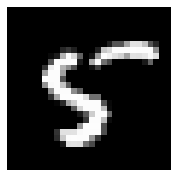

In [19]:
# plot cat image
plt.figure(figsize=(3, 3))
plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
plt.axis("off");

In [20]:
# standardize the data
X_train = X_train / 255
X_test = X_test / 255

X_train = X_train.reshape(X_train.shape[0], -1).T
y_train = y_train.reshape(1, y_train.shape[0])

X_test = X_test.reshape(X_test.shape[0], -1).T
y_test = y_test.reshape(1, y_test.shape[0])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((784, 9912), (784, 3304), (1, 9912), (1, 3304))

In [21]:
# Define the multi-layer model using all the helper functions we wrote before
def L_layer_model(X, y, layers_dims, learning_rate=0.01, num_iterations=100):

    # initialize parameters
    parameters = initialize_parameters(layers_dims, xavier=True)

    # intialize cost list
    cost_list = []

    # iterate over num_iterations
    for i in range(num_iterations):
        # iterate over L-layers to get the final output and the cache
        AL, caches = L_model_forward(X, parameters)  # AL: Last Activation
        
        # compute cost to plot it
        cost = compute_cost(AL, y)

        # iterate over L-layers backward to get gradients
        grads = L_model_backward(AL, y, caches)

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # append each 100th cost to the cost list
        if (i + 1) % 100 == 0:
            print(f"The cost after {i + 1} iterations is: {cost:.4f}")

        if i % 100 == 0:
            cost_list.append(cost)

    # plot the cost curve
    plt.figure(figsize=(10, 6))
    plt.plot(cost_list)
    plt.xlabel("Iterations (per hundreds)")
    plt.ylabel("Loss")
    plt.title(f"Loss curve for the learning rate = {learning_rate}")

    return parameters


def accuracy(X, parameters, y):
    probs, caches = L_model_forward(X, parameters)
    labels = (probs >= 0.5) * 1
    accuracy = np.mean(labels == y) * 100
    return f"The accuracy rate is: {accuracy:.2f}%."

(784, 9912) (1, 9912)
The cost after 100 iterations is: 0.3413
The cost after 200 iterations is: 0.2444
The cost after 300 iterations is: 0.1978
The cost after 400 iterations is: 0.1707
The cost after 500 iterations is: 0.1533
The cost after 600 iterations is: 0.1410
The cost after 700 iterations is: 0.1317
The cost after 800 iterations is: 0.1244
The cost after 900 iterations is: 0.1184
The cost after 1000 iterations is: 0.1135
The cost after 1100 iterations is: 0.1093
The cost after 1200 iterations is: 0.1057
The cost after 1300 iterations is: 0.1024
The cost after 1400 iterations is: 0.0996
The cost after 1500 iterations is: 0.0970
The cost after 1600 iterations is: 0.0947
The cost after 1700 iterations is: 0.0926
The cost after 1800 iterations is: 0.0907
The cost after 1900 iterations is: 0.0890
The cost after 2000 iterations is: 0.0874
The cost after 2100 iterations is: 0.0859
The cost after 2200 iterations is: 0.0845
The cost after 2300 iterations is: 0.0832
The cost after 2400 i

'The accuracy rate is: 97.52%.'

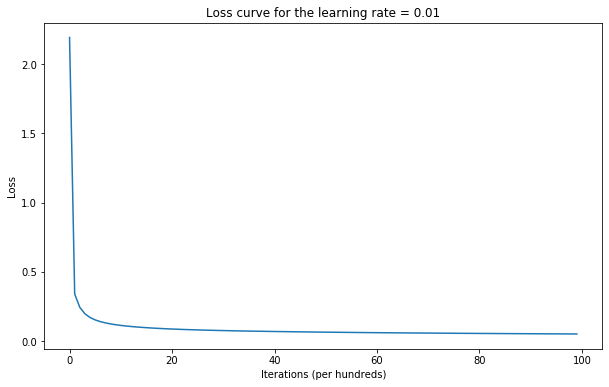

In [22]:
# Setting layers dims
layers_dims = [X_train.shape[0], 64, 16, 1]

# NN with relu activation fn
parameters = L_layer_model(X_train, y_train, layers_dims, learning_rate=0.01, num_iterations=10000)
# Print the accuracy
accuracy(X_test, parameters, y_test)

In [24]:
idx = 10
sample_data = X_test[:, [idx]]
y_test[:, idx]

array([0.])

In [25]:
AL, caches = L_model_forward(sample_data, parameters)
AL

array([[2.97368987e-05]])